## Power generation Forecasting
by Hoang cute

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Read the datasets
import glob
path = r'.\dataset_ansan\weatherdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,encoding = 'unicode_escape')
    df = df.rename(columns={'ÁöÁ¡':'Point','ÀÏ½Ã':'datetime','±â¿Â(¡ÆC)':'Temperature (°C)','´©Àû°­¼ö·®(mm)':'Precipitation (mm)','Ç³Çâ(deg)':'Wind Direction (deg)'
    ,'Ç³¼Ó(m/s)':'Wind Speed ​​(m/s)','ÇöÁö±â¾Ð(hPa)':'Barometric Pressure (hPa)','ÇØ¸é±â¾Ð(hPa)':'Sea Level Pressure (hPa)','½Àµµ(%)':'Humidity (%)',
    'ÀÏ»ç(MJ/m^2)':'Insolation (MJ/m^2)','ÀÏÁ¶(Sec)':'Sunlight (Sec)'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    li.append(df)

df_weather = pd.concat(li, axis=0, ignore_index=True)
df_weather = df_weather.drop_duplicates(keep=False)
df_weather = df_weather.drop(['Point'],axis=1).set_index('datetime')
df_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2),Sunlight (Sec)
datetime,,,,,,,,,
2021-01-01 00:01:00,-8.5,0.0,253.5,0.6,1022.7,1028.0,88.0,0.0,0.0
2021-01-01 00:02:00,-8.4,0.0,269.8,0.5,1022.7,1028.0,87.9,0.0,0.0
2021-01-01 00:03:00,-8.3,0.0,267.5,0.6,1022.8,1028.1,86.9,0.0,0.0
2021-01-01 00:04:00,-8.4,0.0,245.4,0.5,1022.8,1028.1,85.9,0.0,0.0
2021-01-01 00:05:00,-8.5,0.0,257.3,0.6,1022.8,1028.1,84.9,0.0,0.0


In [4]:
print(len(df_weather))

742395


In [5]:
davg_hourly = df_weather.resample('H').median()
davg_solar_last = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').last()
davg_solar_first = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').first()
davg_solar = davg_solar_last.subtract(davg_solar_first,fill_value=0).rename(columns={'Insolation (MJ/m^2)':'Insolation (MJ/m^2) per hour','Sunlight (Sec)':'Sunlight (Sec) per hour'})
davg_solar[davg_solar<0] = 0
fr_weather = pd.merge(davg_hourly,davg_solar,left_index=True,right_index=True).drop(['Insolation (MJ/m^2)','Sunlight (Sec)'],axis=1)
fr_weather = fr_weather.reset_index()
fr_weather = fr_weather[(fr_weather.datetime < '2022-01-01 00:00:00') | (fr_weather.datetime >= '2022-02-01 00:00:00')].set_index('datetime')

fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-8.9,0.0,282.60,0.8,1022.70,1028.00,85.90,0.0,0.0
2021-01-01 01:00:00,-9.6,0.0,247.65,1.0,1022.40,1027.70,86.00,0.0,0.0
2021-01-01 02:00:00,-9.6,0.0,246.10,1.1,1022.90,1028.20,85.10,0.0,0.0
2021-01-01 03:00:00,-9.9,0.0,127.75,0.8,1022.95,1028.25,83.65,0.0,0.0
2021-01-01 04:00:00,-9.8,0.0,137.70,1.5,1022.30,1027.60,86.15,0.0,0.0


In [6]:
print(len(davg_hourly))
print(len(davg_solar_last))
print(len(davg_solar_first))
print(len(fr_weather))


12385
12385
12385
11641


In [7]:
fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-8.9,0.0,282.60,0.8,1022.70,1028.00,85.90,0.0,0.0
2021-01-01 01:00:00,-9.6,0.0,247.65,1.0,1022.40,1027.70,86.00,0.0,0.0
2021-01-01 02:00:00,-9.6,0.0,246.10,1.1,1022.90,1028.20,85.10,0.0,0.0
2021-01-01 03:00:00,-9.9,0.0,127.75,0.8,1022.95,1028.25,83.65,0.0,0.0
2021-01-01 04:00:00,-9.8,0.0,137.70,1.5,1022.30,1027.60,86.15,0.0,0.0


In [8]:
fr_weather.to_csv('Ansan_hourly.csv')

In [9]:
# Read the datasets
import glob
path = r'.\dataset_ansan\ensdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_energy = pd.concat(li, axis=0, ignore_index=True)
df_energy = df_energy[pd.to_numeric(df_energy['Hour'], errors='coerce').notnull()]
#df_energy = df_energy.drop_duplicates(keep=False)
df_energy['datetime'] = pd.to_datetime(df_energy['Date'] + ' ' + df_energy['Hour'] + ':00:00')
df_energy = df_energy.drop(['Date','Hour'],axis=1).set_index('datetime')
df_energy.head()

,P(kWh),h_max
datetime,,
2021-01-01 00:00:00,0,48060.0
2021-01-01 01:00:00,0,48060.0
2021-01-01 02:00:00,0,48060.0
2021-01-01 03:00:00,0,48060.0
2021-01-01 04:00:00,0,48060.0


In [10]:
print(len(df_energy))

11566


In [11]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [12]:
df_merge = pd.merge(
    fr_weather,
    df_energy,
    how="outer",
    on="datetime",
    sort=True
)
df_merge = df_convert_dtypes(df_merge, np.object, np.float64)
df_merge.head(30)

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2021-01-01 00:00:00,-8.90,0.0,282.60,0.80,1022.70,1028.00,85.90,0.00,0.0,0.0,48060.0
2021-01-01 01:00:00,-9.60,0.0,247.65,1.00,1022.40,1027.70,86.00,0.00,0.0,0.0,48060.0
2021-01-01 02:00:00,-9.60,0.0,246.10,1.10,1022.90,1028.20,85.10,0.00,0.0,0.0,48060.0
2021-01-01 03:00:00,-9.90,0.0,127.75,0.80,1022.95,1028.25,83.65,0.00,0.0,0.0,48060.0
2021-01-01 04:00:00,-9.80,0.0,137.70,1.50,1022.30,1027.60,86.15,0.00,0.0,0.0,48060.0
2021-01-01 05:00:00,-9.55,0.0,111.90,1.45,1021.80,1027.10,87.10,0.00,0.0,0.0,48060.0
2021-01-01 06:00:00,-8.40,0.0,138.40,1.30,1022.00,1027.20,88.10,0.00,0.0,0.0,48060.0
2021-01-01 07:00:00,-8.30,0.0,142.10,1.20,1022.00,1027.20,89.20,0.00,0.0,0.0,48060.0
2021-01-01 08:00:00,-7.80,0.0,120.00,1.40,1022.10,1027.30,89.70,0.17,0.0,4.0,48064.0


In [13]:
print(len(df_merge))

12250


In [14]:
df_merge.describe()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
count,11640.000000,11165.000000,11626.000000,11626.000000,11635.000000,11635.000000,11640.000000,11638.000000,11640.000000,11566.000000,11566.000000
mean,12.499768,1.322651,194.941295,1.948009,1012.378853,1017.175875,69.499888,0.606287,1035.386598,16.416393,140838.877226
std,10.505285,5.460849,93.092043,1.362715,7.864589,8.042985,20.590106,0.898658,1505.100686,27.974339,54379.004436
min,-18.200000,0.000000,0.000000,0.000000,991.300000,996.000000,15.550000,0.000000,0.000000,0.000000,48060.000000
25%,4.750000,0.000000,114.600000,0.900000,1006.300000,1011.000000,53.950000,0.000000,0.000000,0.000000,93102.000000
50%,12.900000,0.000000,227.550000,1.650000,1012.800000,1017.600000,70.375000,0.000000,0.000000,0.000000,147751.000000
75%,21.100000,0.000000,275.350000,2.800000,1018.200000,1023.100000,88.112500,1.040000,2820.000000,26.000000,182855.000000
max,35.700000,70.900000,351.600000,8.500000,1032.200000,1037.600000,99.900000,3.500000,3600.000000,345.000000,239889.000000


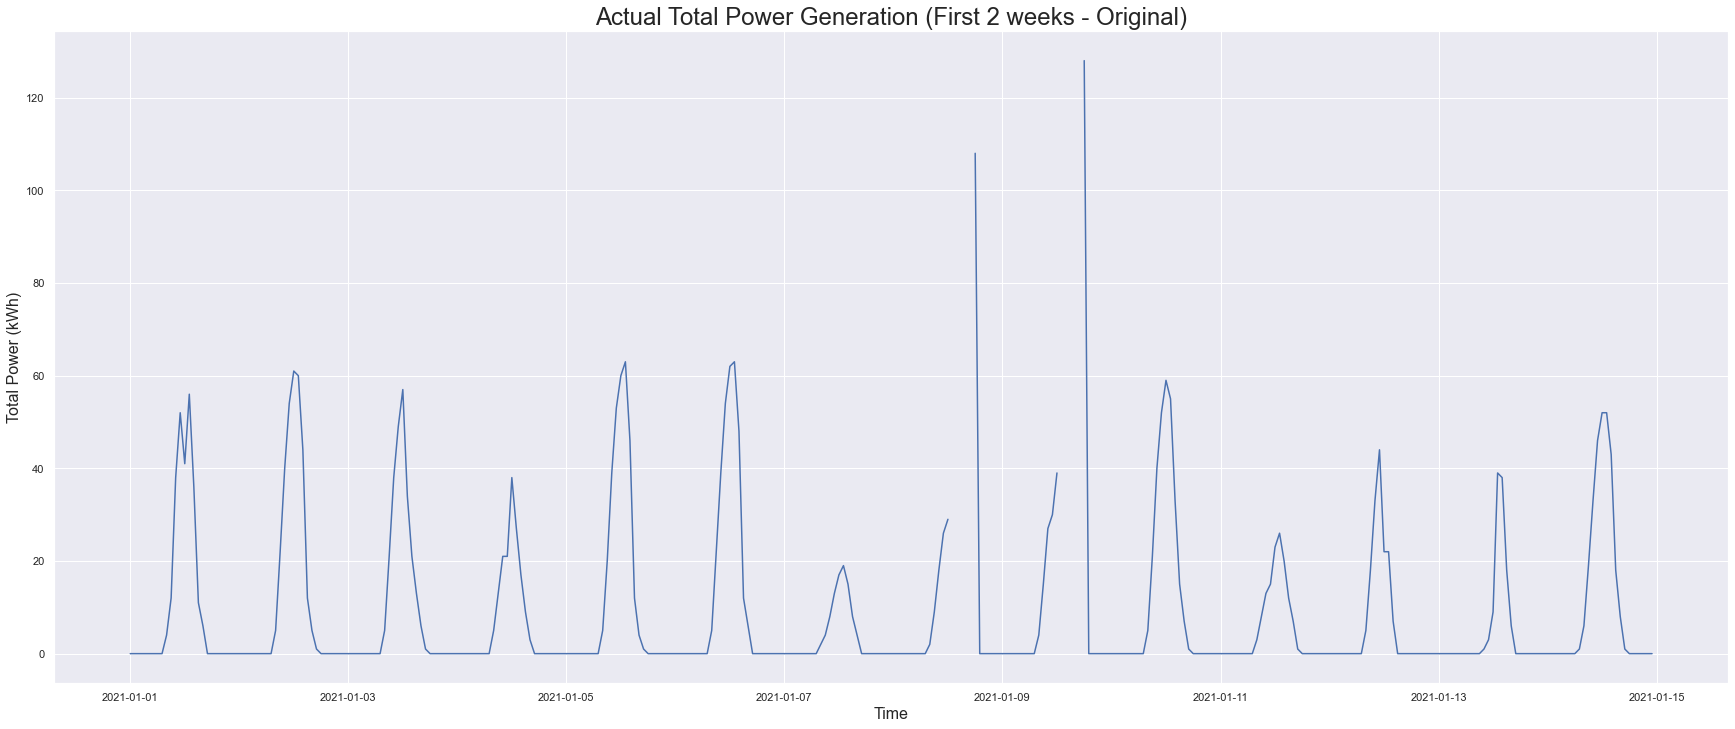

In [15]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax
    # Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_merge, column='P(kWh)', ylabel='Total Power (kWh)',
                 title='Actual Total Power Generation (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [16]:
# Display the rows with null values

df_merge[df_merge.isnull().any(axis=1)].tail()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2022-05-29 23:00:00,19.3,NaN,252.35,1.25,999.7,1004.3,79.10,0.0,0.0,0.0,238991.0
2022-05-30 21:00:00,17.4,NaN,288.05,2.60,1000.1,1004.7,90.70,0.0,0.0,0.0,239254.0
2022-05-30 22:00:00,16.4,NaN,278.45,1.50,1000.7,1005.4,92.35,0.0,0.0,0.0,239254.0
2022-05-30 23:00:00,15.8,NaN,281.30,0.60,1001.1,1005.8,91.10,0.0,0.0,0.0,239254.0
2022-06-01 00:00:00,17.9,0.0,98.90,0.80,1004.3,1008.9,48.10,0.0,0.0,NaN,NaN


In [17]:
# Fill null values using interpolation

df_merge.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [18]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_merge.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

Temperature (°C)                12232
Precipitation (mm)               2196
Wind Direction (deg)            11701
Wind Speed ​​(m/s)              11753
Barometric Pressure (hPa)       12250
Sea Level Pressure (hPa)        12250
Humidity (%)                    12250
Insolation (MJ/m^2) per hour     5728
Sunlight (Sec) per hour          4299
P(kWh)                           6209
h_max                           12250
dtype: int64


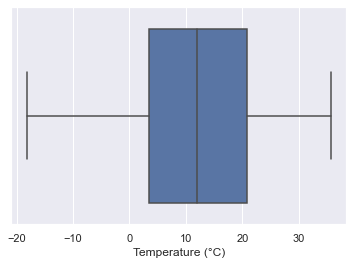

In [19]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_merge['Temperature (°C)'])
plt.show()

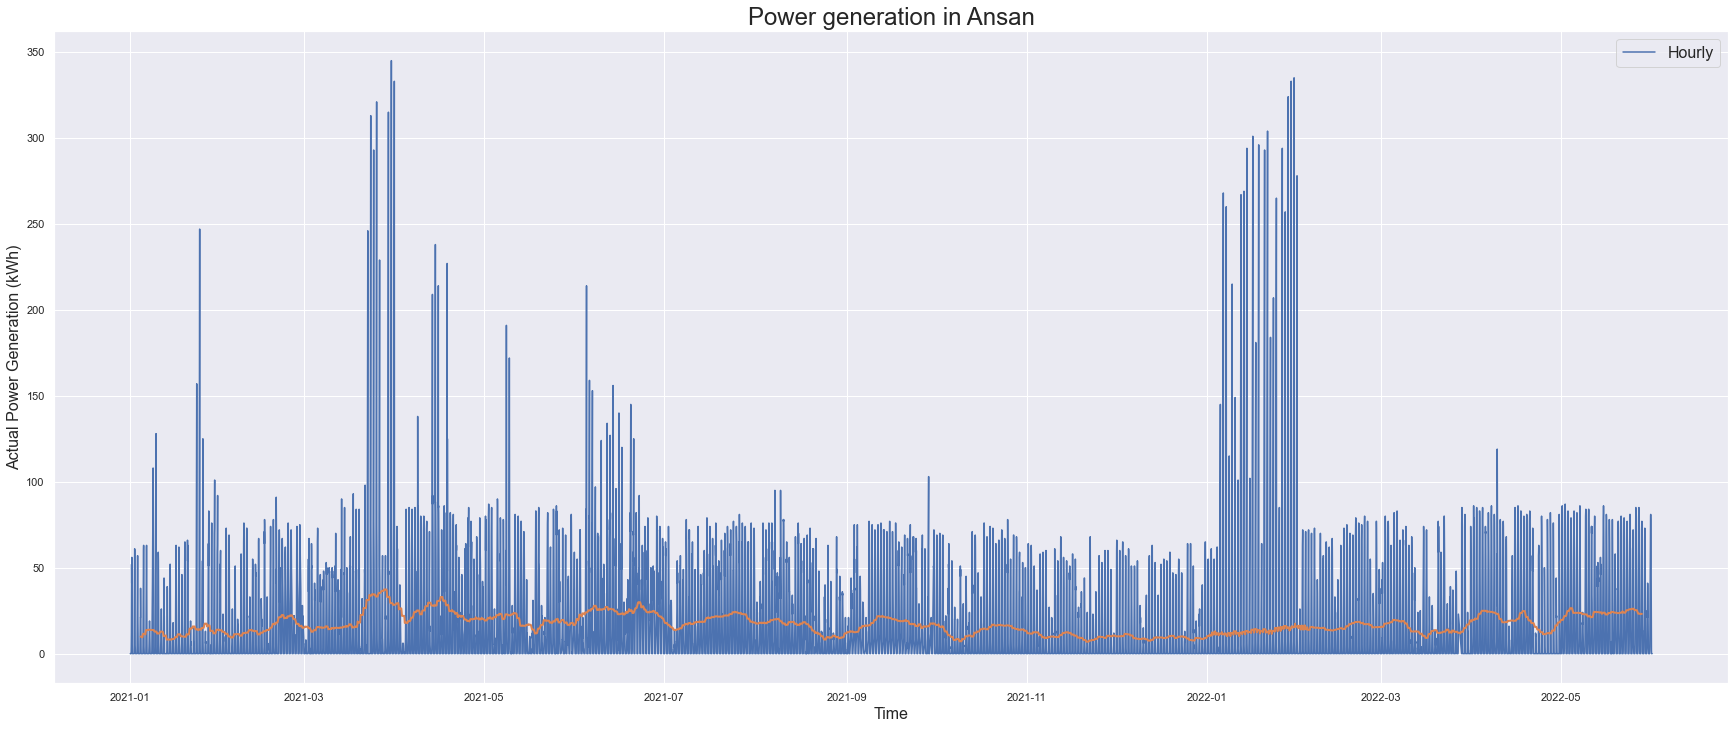

In [20]:
# Plot the 'rain_1h' for Bilbao
rolling = df_merge['P(kWh)'].rolling(24*7, center=True).mean()

ax = plot_series(df_merge, 'P(kWh)', 
                 label='Hourly', ylabel='Actual Power Generation (kWh)',
                 title='Power generation in Ansan')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

## <a id='ref14'>2.3. Autocorrelation, partial autocorrelation and cross-correlation</a> 

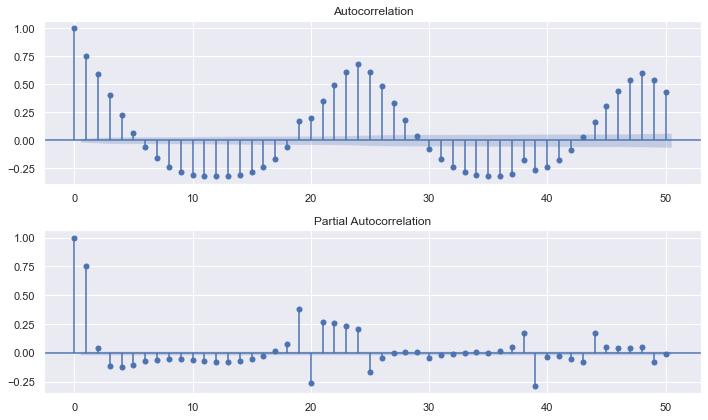

In [21]:
# Plot autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_merge['P(kWh)'], lags=50, ax=ax1)
plot_pacf(df_merge['P(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [22]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12250 entries, 2021-01-01 00:00:00 to 2022-06-01 00:00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Temperature (°C)              12250 non-null  float64
 1   Precipitation (mm)            12250 non-null  float64
 2   Wind Direction (deg)          12250 non-null  float64
 3   Wind Speed ​​(m/s)            12250 non-null  float64
 4   Barometric Pressure (hPa)     12250 non-null  float64
 5   Sea Level Pressure (hPa)      12250 non-null  float64
 6   Humidity (%)                  12250 non-null  float64
 7   Insolation (MJ/m^2) per hour  12250 non-null  float64
 8   Sunlight (Sec) per hour       12250 non-null  float64
 9   P(kWh)                        12250 non-null  float64
 10  h_max                         12250 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


In [23]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_merge.corr(method='pearson')
print(correlations.columns)
print(correlations['P(kWh)'].sort_values(ascending=False).to_string())

Index(['Temperature (°C)', 'Precipitation (mm)', 'Wind Direction (deg)',
       'Wind Speed ​​(m/s)', 'Barometric Pressure (hPa)',
       'Sea Level Pressure (hPa)', 'Humidity (%)',
       'Insolation (MJ/m^2) per hour', 'Sunlight (Sec) per hour', 'P(kWh)',
       'h_max'],
      dtype='object')
P(kWh)                          1.000000
Insolation (MJ/m^2) per hour    0.795134
Sunlight (Sec) per hour         0.667950
Wind Speed ​​(m/s)              0.367858
Temperature (°C)                0.234655
Wind Direction (deg)            0.084248
h_max                          -0.022552
Precipitation (mm)             -0.054121
Barometric Pressure (hPa)      -0.060865
Sea Level Pressure (hPa)       -0.065386
Humidity (%)                   -0.429182


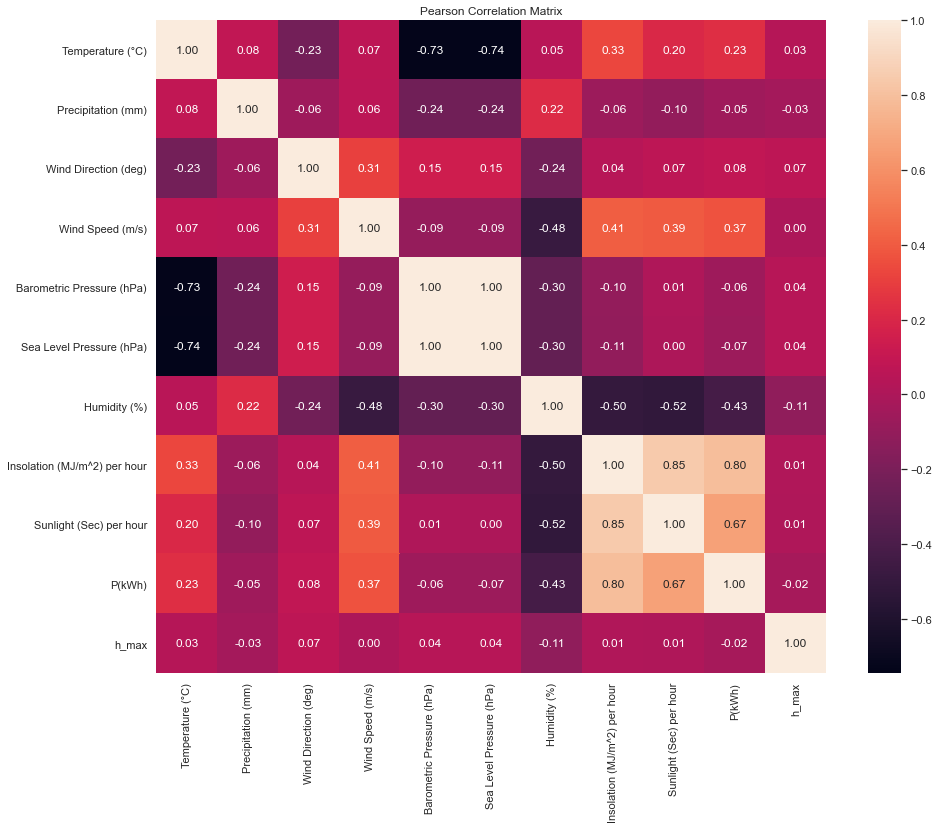

In [24]:
# Plot Pearson correlation matrix

correlations = df_merge.corr(method='pearson')
fig = plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [25]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Barometric Pressure (hPa)     Sea Level Pressure (hPa)        0.999848
Sea Level Pressure (hPa)      Barometric Pressure (hPa)       0.999848
Insolation (MJ/m^2) per hour  Sunlight (Sec) per hour         0.845756
                              P(kWh)                          0.795134
Sunlight (Sec) per hour       Insolation (MJ/m^2) per hour    0.845756
P(kWh)                        Insolation (MJ/m^2) per hour    0.795134


## <a id='ref17'>Feature selection</a> 

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [27]:
train_end_idx = 8760
cv_end_idx = 10176
test_end_idx = 12000

In [28]:
df_final  = df_merge.copy()
# Wind Direction (deg)            0.086512
# h_max                           0.035325
# Barometric Pressure (hPa)      -0.010425
# Sea Level Pressure (hPa)       -0.016479
# Precipitation (mm)             -0.092167
# Humidity (%)                   -0.548498
X = df_final[df_final.columns.drop(['P(kWh)','Wind Direction (deg)','h_max','Barometric Pressure (hPa)','Sea Level Pressure (hPa)','Precipitation (mm)'])].values
y = df_final['P(kWh)'].values

y = y.reshape(-1, 1)

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [30]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [31]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

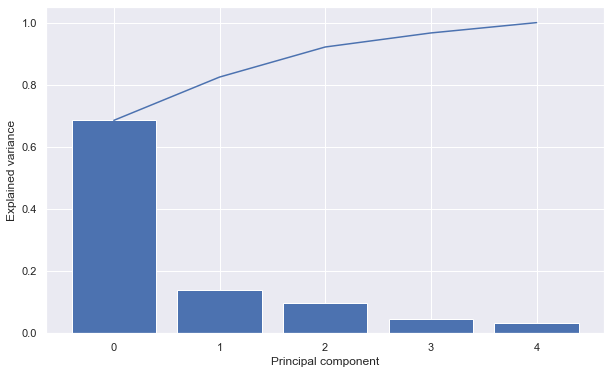

In [33]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [34]:
pca = PCA(n_components=0.95)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [35]:
X_pca.shape

(12250, 4)

In [36]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 12
future_target = 0

In [37]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [38]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [39]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [40]:
batch_size = 16
buffer_size = 1000

In [41]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [42]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [43]:
y_test = y_test.reshape(-1, 1)

y_test_inv = scaler_y.inverse_transform(y_test)

In [44]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## 1. XG Boost

In [45]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [46]:
X_train_xgb.shape

(8748, 60)

## 2. LSTM

In [47]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from math import sqrt

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [48]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
547/547 [==============================] - 13s 11ms/step - loss: 0.0071 - root_mean_squared_error: 0.0792 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 2/120
547/547 [==============================] - 6s 10ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1301
Epoch 3/120
547/547 [==============================] - 5s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 4/120
547/547 [==============================] - 5s 9ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 5/120
547/547 [==============================] - 5s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 6/120
547/547 [==============================] - 5s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.02

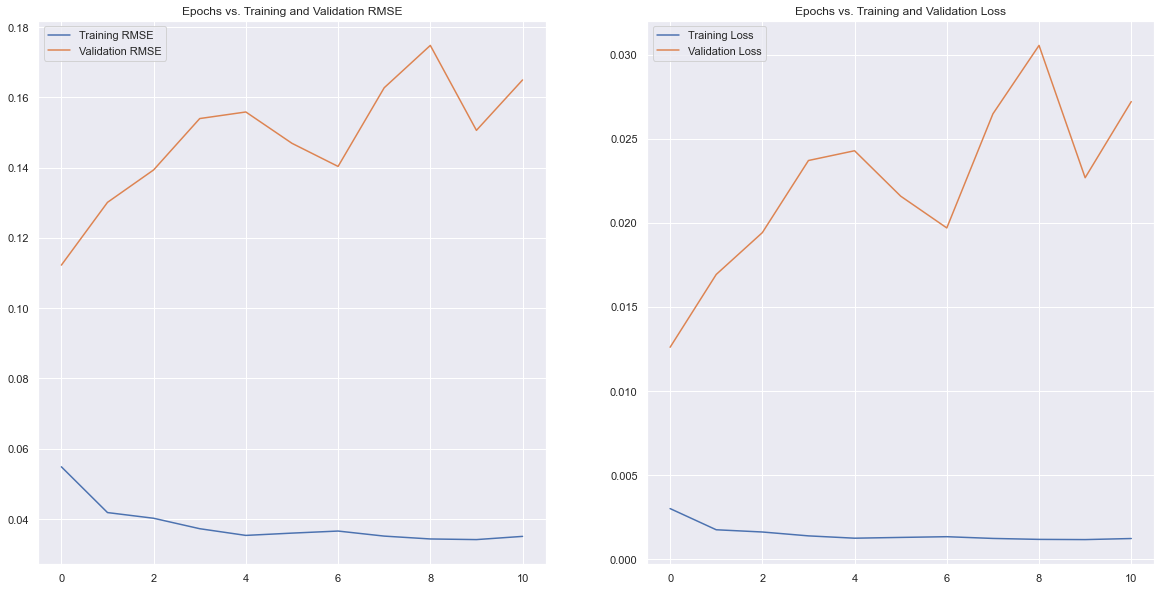

In [49]:
plot_model_rmse_and_loss(history)

In [50]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

NameError: name 'sqrt' is not defined

## Stacked LSTM

In [ ]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [ ]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
547/547 [==============================] - 17s 17ms/step - loss: 0.0050 - root_mean_squared_error: 0.0973 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 2/120
547/547 [==============================] - 8s 14ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 3/120
547/547 [==============================] - 8s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1317
Epoch 4/120
547/547 [==============================] - 8s 14ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1332
Epoch 5/120
547/547 [==============================] - 8s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 6/120
547/547 [==============================] - 8s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 

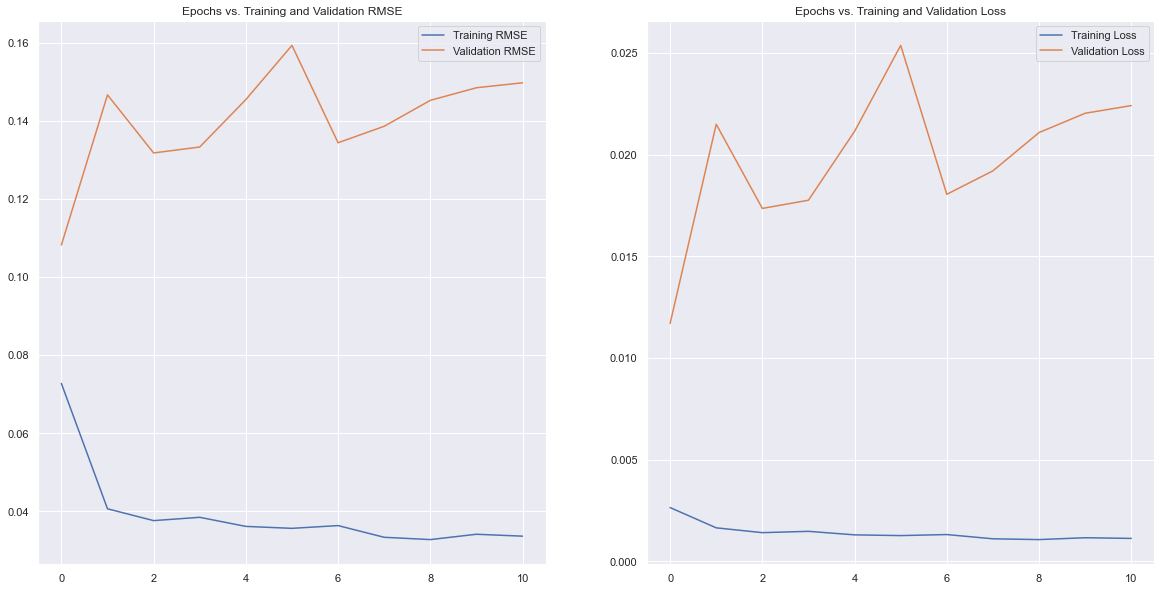

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 11.701


## 1D CNN

In [ ]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
547/547 [==============================] - 8s 6ms/step - loss: 0.0050 - root_mean_squared_error: 0.0975 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 2/120
547/547 [==============================] - 3s 6ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276
Epoch 3/120
547/547 [==============================] - 3s 6ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1522
Epoch 4/120
547/547 [==============================] - 3s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0402 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 5/120
547/547 [==============================] - 3s 5ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1647
Epoch 6/120
547/547 [==============================] - 3s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0251 

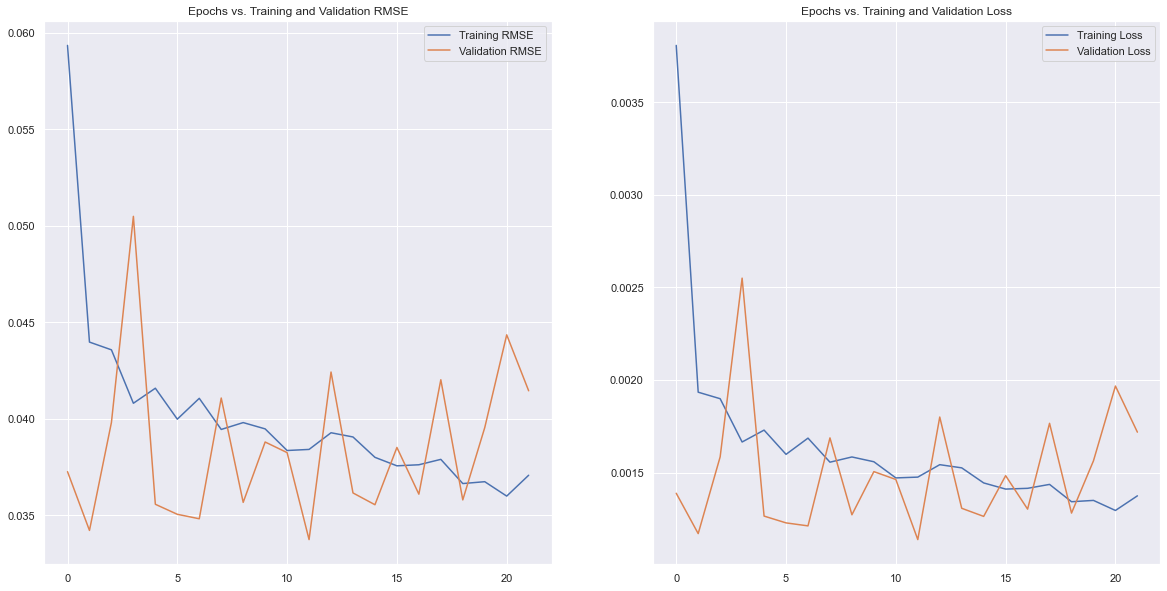

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 5.78


## CNN-LSTM

In [ ]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [ ]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
547/547 [==============================] - 12s 13ms/step - loss: 0.0069 - root_mean_squared_error: 0.0647 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 2/120
547/547 [==============================] - 6s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/120
547/547 [==============================] - 6s 12ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 4/120
547/547 [==============================] - 6s 11ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 5/120
547/547 [==============================] - 6s 11ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 6/120
547/547 [==============================] - 6s 11ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 

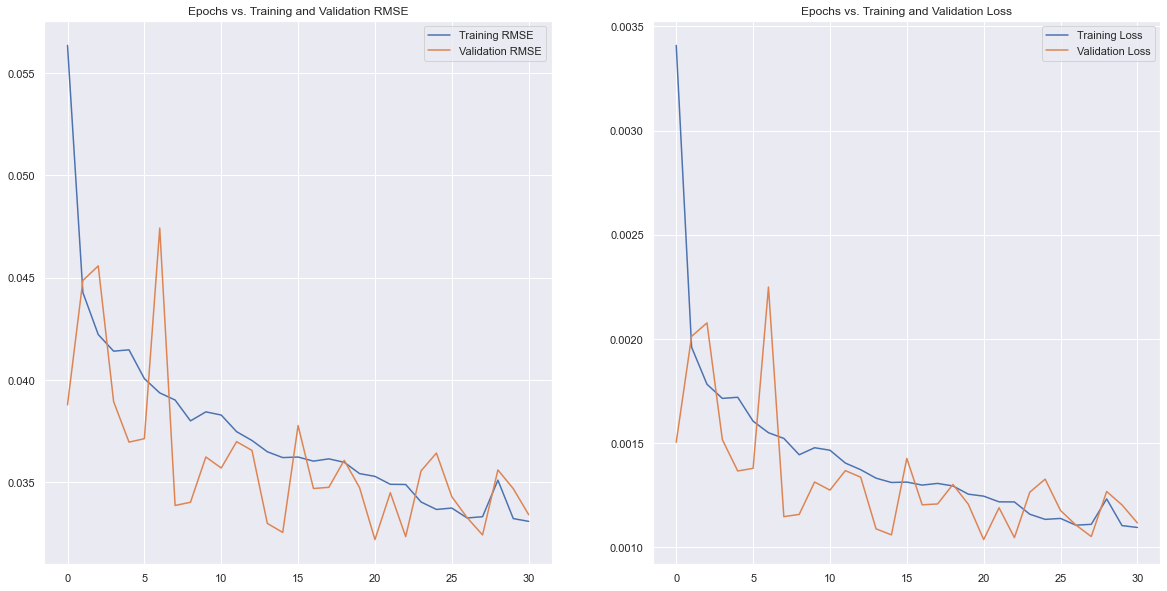

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 6.084


In [ ]:
X_test.shape

(1812, 12, 5)

## MLP

In [ ]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
547/547 [==============================] - 6s 8ms/step - loss: 0.0047 - root_mean_squared_error: 0.0546 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 2/120
547/547 [==============================] - 4s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 3/120
547/547 [==============================] - 5s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/120
547/547 [==============================] - 4s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 5/120
547/547 [==============================] - 4s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 6/120
547/547 [==============================] - 4s 8ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0014 

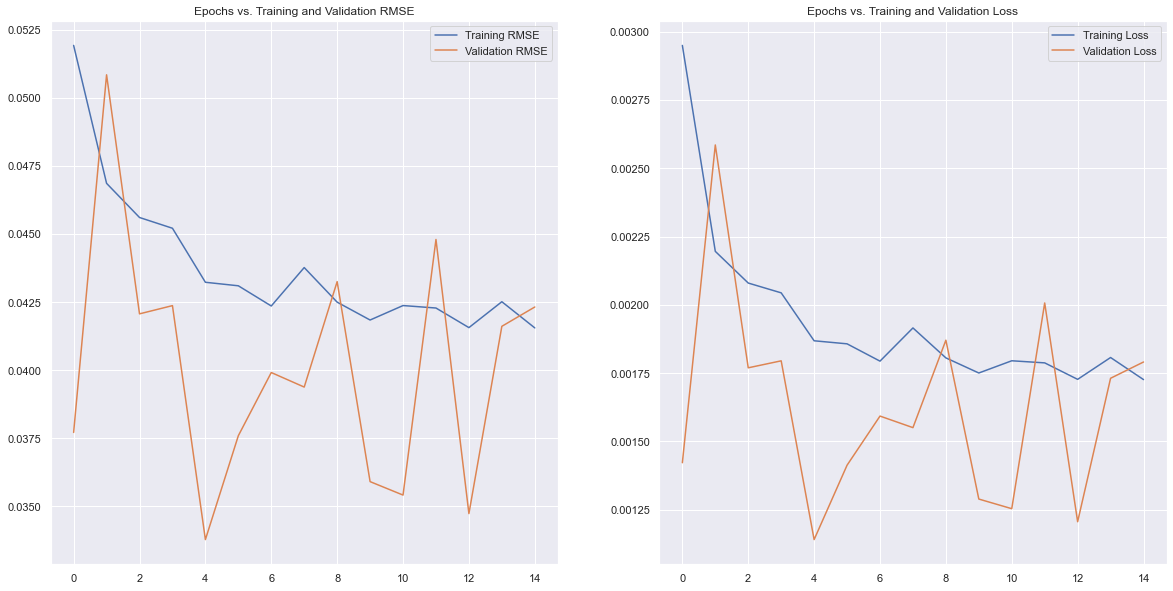

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 5.318


## Autoencoder

In [ ]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [ ]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
547/547 [==============================] - 60s 99ms/step - loss: 0.0078 - root_mean_squared_error: 0.0691 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519ss: 0.0080 - root
Epoch 2/50
547/547 [==============================] - 50s 91ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 3/50
547/547 [==============================] - 53s 96ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530_
Epoch 4/50
547/547 [==============================] - 49s 89ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 5/50
547/547 [==============================] - 50s 91ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 6/50
547/547 [==============================] - 52s 95ms/step - loss: 0.0019 - root_mean_squared_error: 0.

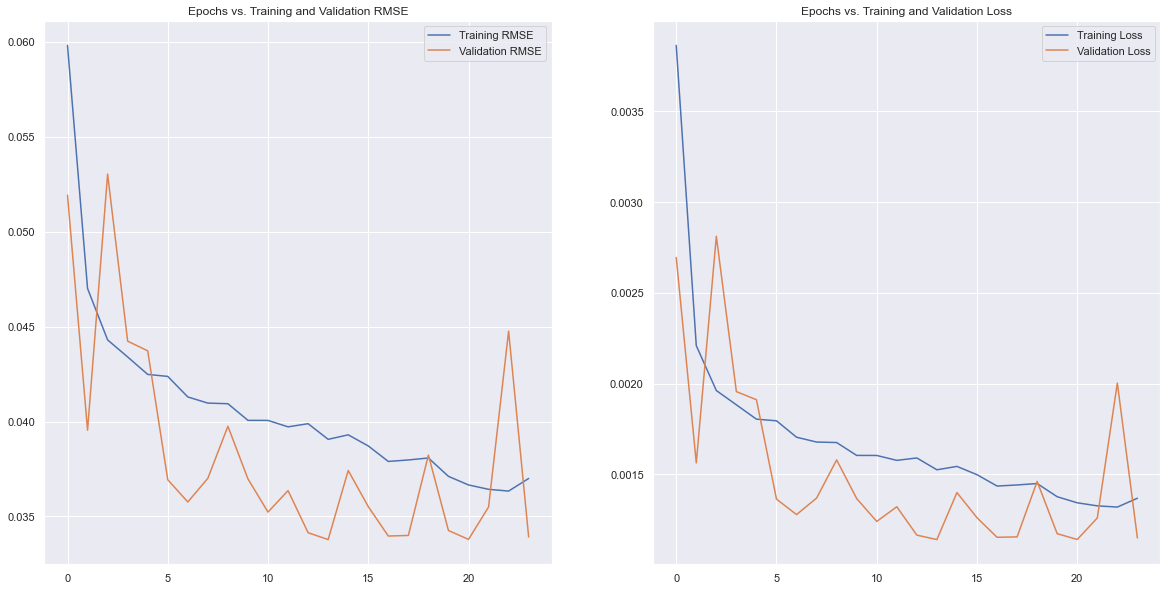

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

RMSE of hour-ahead electricity price Encoder-Decoder forecast: 5.786


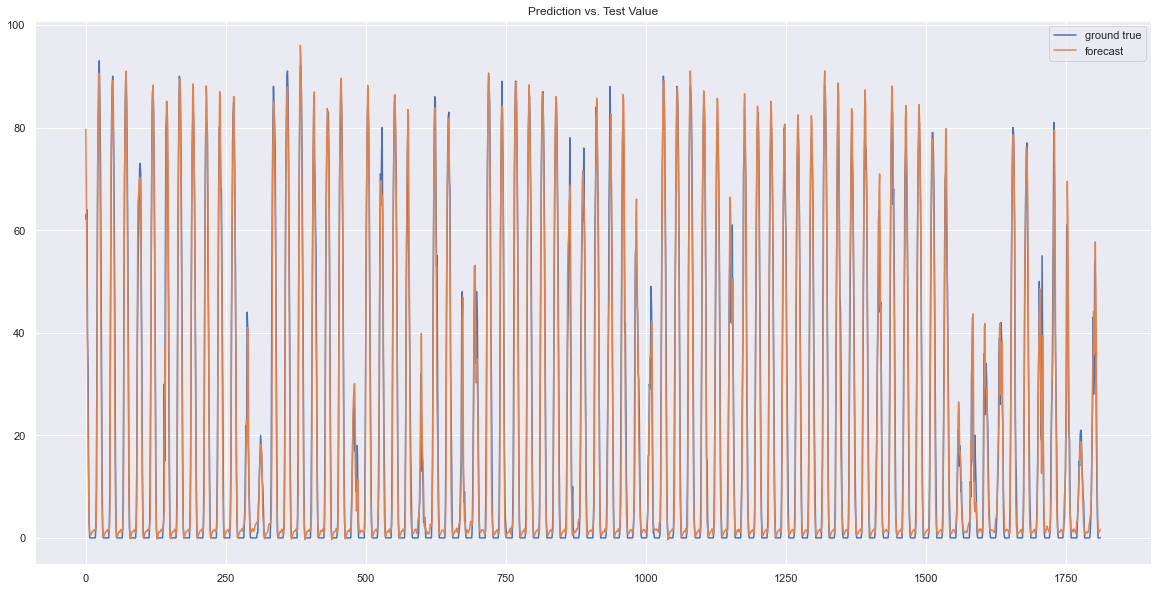

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_test_inv,label='ground true')
plt.plot(multivariate_mlp_forecast,label='forecast')
plt.title('Prediction vs. Test Value')
plt.legend()